# Single Object Segmentation


Using [Synthetic MNIST](https://github.com/ayulockin/synthetic_datasets/tree/master/MNIST)

In [108]:
import numpy as np
import os
import pandas as pd
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

## Load the Synthetic MNIST dataset

In [2]:
dataset_path = 'dataset/synthetic_mnist/'
training_csv_path = os.path.join(dataset_path, 'training_data.csv')
testing_csv_path = os.path.join(dataset_path, 'test_data.csv')
training_data_path = os.path.join(dataset_path, 'MNIST_Converted_Training')
testing_data_path = os.path.join(dataset_path, 'MNIST_Converted_Testing')

In [43]:
def get_csv(path):
    df = pd.read_csv(path, names=['name', 'label', 'bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax'])
    return df

In [9]:
training_csv = get_csv(training_csv_path)
testing_csv = get_csv(testing_csv_path)

In [10]:
training_csv.head()

,name,label,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,bbox
0,converted_training1.png,4,0.49,0.15,0.77,0.43,"[0.49, 0.15, 0.77, 0.43]"
1,converted_training2.png,1,0.64,0.26,0.92,0.54,"[0.64, 0.26, 0.92, 0.54]"
2,converted_training3.png,0,0.42,0.39,0.70,0.67,"[0.42, 0.39, 0.7, 0.67]"
3,converted_training4.png,7,0.58,0.10,0.86,0.38,"[0.58, 0.1, 0.86, 0.38]"
4,converted_training5.png,8,0.21,0.23,0.49,0.51,"[0.21, 0.23, 0.49, 0.51]"


In [11]:
testing_csv.head()

,name,label,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,bbox
0,converted_testing1.png,2,0.20,0.45,0.48,0.73,"[0.2, 0.45, 0.48, 0.73]"
1,converted_testing2.png,0,0.02,0.03,0.30,0.31,"[0.02, 0.03, 0.3, 0.31]"
2,converted_testing3.png,4,0.55,0.39,0.83,0.67,"[0.55, 0.39, 0.83, 0.67]"
3,converted_testing4.png,8,0.38,0.42,0.66,0.70,"[0.38, 0.42, 0.66, 0.7]"
4,converted_testing5.png,7,0.69,0.17,0.97,0.45,"[0.69, 0.17, 0.97, 0.45]"


## Create Data Input Pipeline

In [64]:
def preprocess_train(image_name, label, bbox):
    image = tf.io.read_file(training_data_path + '/' + image_name)
    image = tf.image.decode_image(image, channels=1)
    return image, {'label': label, 'bbox': bbox}


@tf.function
def preprocess_test(image_name, label, bbox):
    image = tf.io.read_file(testing_data_path + '/' + image_name)
    image = tf.image.decode_image(image, channels=1)
    return image, {'label': label, 'bbox': bbox}

In [15]:
SHUFFLE_PARAM = 1024
BATCH_PARAM = 32
TUNE_PARAM = tf.data.experimental.AUTOTUNE

In [36]:
dataset = tf.data.Dataset.from_tensor_slices((['a', 'b'], [1, 2], [[3, 4], [5, 6]]))
list(dataset.as_numpy_iterator())

[(b'a', 1, array([3, 4], dtype=int32)), (b'b', 2, array([5, 6], dtype=int32))]

In [55]:
train_loader = tf.data.Dataset.from_tensor_slices((training_csv.name.values, training_csv.label.values, training_csv[['bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']].values))

In [67]:
train_loader = train_loader.map(preprocess_train, num_parallel_calls=TUNE_PARAM).shuffle(SHUFFLE_PARAM).batch(BATCH_PARAM).prefetch(TUNE_PARAM)

In [68]:
test_loader = tf.data.Dataset.from_tensor_slices((testing_csv.name.values, testing_csv.label.values, testing_csv[['bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']].values))

In [69]:
test_loader = test_loader.map(preprocess_test, num_parallel_calls=TUNE_PARAM).batch(BATCH_PARAM).prefetch(TUNE_PARAM)

In [106]:
# Ref: https://www.tensorflow.org/tutorials/load_data/images
def show_batch(image_batch, label_batch, bbox):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        img = np.squeeze(image_batch[n], axis=-1)
        img = cv2.rectangle(img,(bbox[n][0],bbox[n][1]),(bbox[n][2],bbox[n][3]),(255,0,0),2)
        plt.imshow(img, cmap='gray')
        plt.title(label_batch[n])
        plt.axis('off')

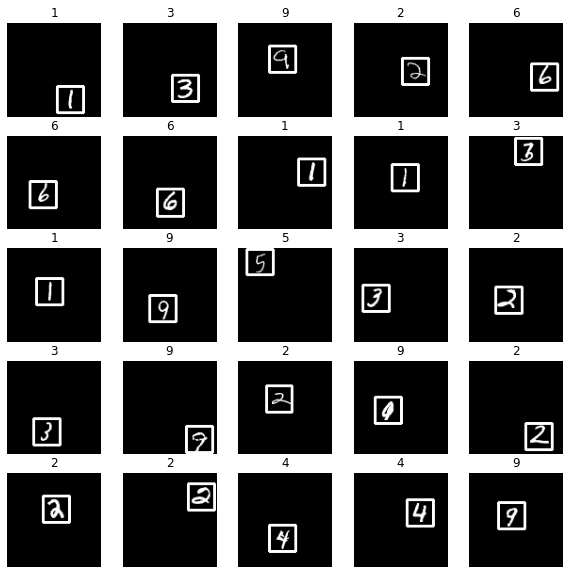

In [109]:
img_samples, label_bbox = next(iter(train_loader))
img_samples.shape, label_bbox['label'].shape, label_bbox['bbox'].shape

show_batch(img_samples, label_bbox['label'].numpy(), (label_bbox['bbox'].numpy()*100).astype('int32'))

## Creating the Model

In [81]:
def get_feature_extractor(input):
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(input)
    x = tf.keras.layers.MaxPooling2D(3)(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(3)(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(3)(x)
    x = tf.keras.layers.Flatten()(x)
    return x

In [117]:
def get_classifier(feature_extractor):
    #x = tf.keras.layers.Dense(1024, activation='relu')(feature_extractor)
    x = tf.keras.layers.Dense(128, activation='relu')(feature_extractor)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(10, activation='softmax', name='label')(x)
    return x

In [118]:
def get_bbox_regressor(feature_extractor):
    #x = tf.keras.layers.Dense(1024, activation='relu')(feature_extractor)
    x = tf.keras.layers.Dense(128, activation='relu')(feature_extractor)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(4, activation='sigmoid', name='bbox')(x)
    return x

In [119]:
def get_model():
    input_layer = tf.keras.layers.Input(shape=(100,100,1))
    feature_extractor = get_feature_extractor(input_layer)
    classifier = get_classifier(feature_extractor)
    bbox_regressor = get_bbox_regressor(feature_extractor)
    model = tf.keras.models.Model(inputs=[input_layer], outputs=[classifier, bbox_regressor])
    return model

In [120]:
model = get_model()

In [121]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 98, 98, 16)   160         input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_23 (MaxPooling2D) (None, 32, 32, 16)   0           conv2d_24[0][0]                  
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 30, 30, 32)   4640        max_pooling2d_23[0][0]           
____________________________________________________________________________________________

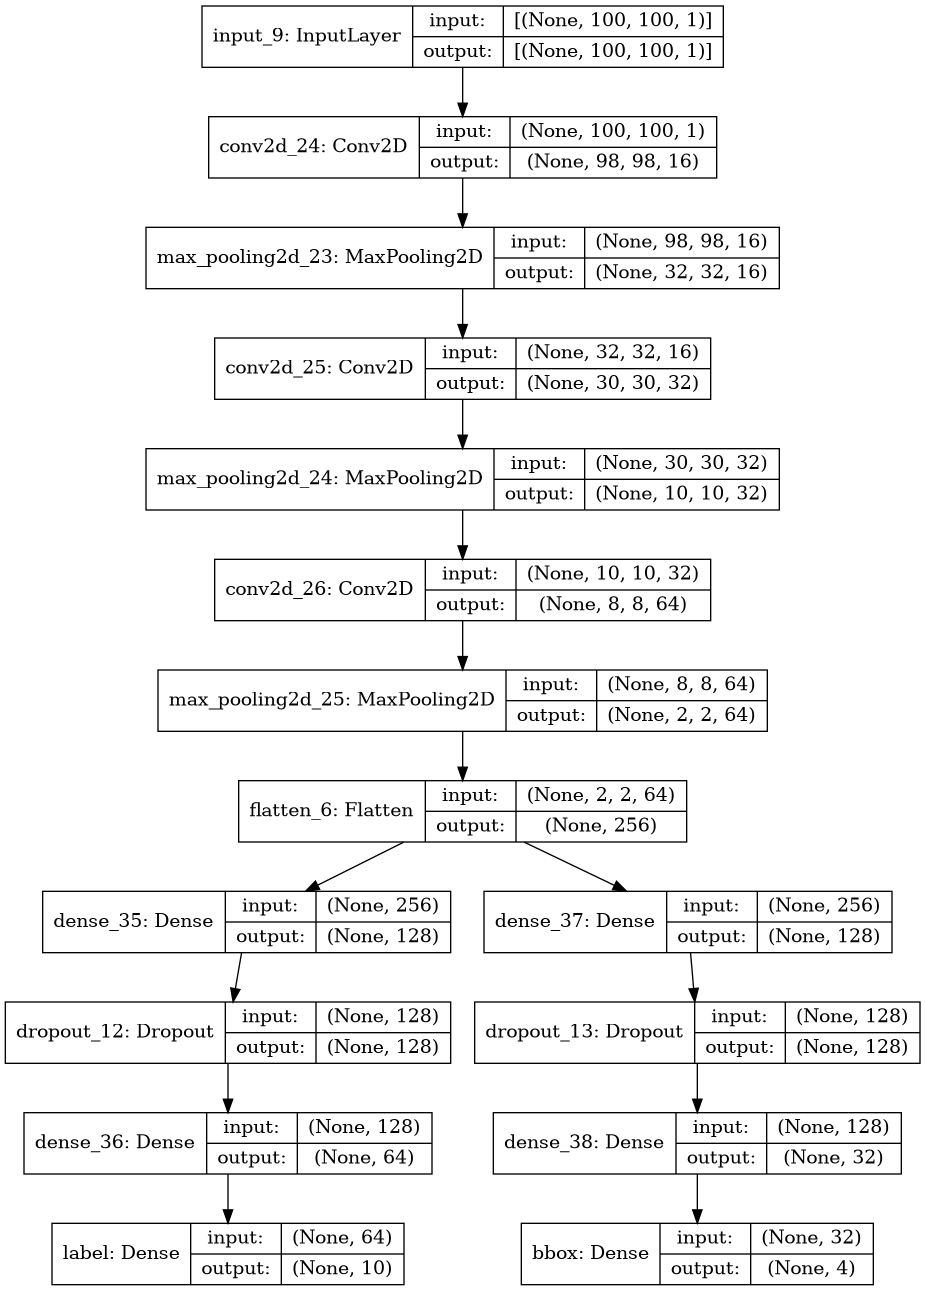

In [122]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [105]:
losses = {
    'label': 'sparse_categorical_crossentropy',
    'bbox': 'mse'
}

loss_weight = {
    'label': 1.0,
    'bbox': 1.0
}

In [125]:
early_stopper_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs', 
    histogram_freq=0, 
    write_graph=True, 
    update_freq='epoch',
)


In [126]:
model.compile('adam', loss=losses, loss_weights=loss_weight, metrics=['acc'])

In [127]:
%load_ext tensorboard
%tensorboard --logdir=logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [128]:
history = model.fit(
    train_loader,
    epochs=100,
    validation_data=test_loader,
    callbacks=[early_stopper_callback, tensorboard_callback],
    verbose=1
)

Epoch 1/100
1875/1875 [==============================] - 42s 20ms/step - loss: 0.5046 - label_loss: 0.5022 - bbox_loss: 0.0024 - label_acc: 0.8346 - bbox_acc: 0.9315 - val_loss: 0.4007 - val_label_loss: 0.3994 - val_bbox_loss: 0.0014 - val_label_acc: 0.8630 - val_bbox_acc: 0.9545
Epoch 2/100
1875/1875 [==============================] - 37s 20ms/step - loss: 0.4405 - label_loss: 0.4384 - bbox_loss: 0.0021 - label_acc: 0.8555 - bbox_acc: 0.9358 - val_loss: 0.3800 - val_label_loss: 0.3789 - val_bbox_loss: 0.0012 - val_label_acc: 0.8716 - val_bbox_acc: 0.9536
Epoch 3/100
1875/1875 [==============================] - 39s 21ms/step - loss: 0.4103 - label_loss: 0.4085 - bbox_loss: 0.0018 - label_acc: 0.8640 - bbox_acc: 0.9395 - val_loss: 0.3641 - val_label_loss: 0.3629 - val_bbox_loss: 0.0011 - val_label_acc: 0.8802 - val_bbox_acc: 0.9581
Epoch 4/100
1875/1875 [==============================] - 36s 19ms/step - loss: 0.3888 - label_loss: 0.3870 - bbox_loss: 0.0018 - label_acc: 0.8703 - bbox_acc

## Model Testing

In [178]:
def test():
    for i in test_loader.take(1):
        images = i[0]
        labels = i[1]['label'].numpy()
        bboxs = (i[1]['bbox'].numpy()*100).astype('int32')
        predictions = model.predict(images)
        pred_labels = predictions[0]
        pred_bboxs = (predictions[1]*100).astype('int32')
        plt.figure(figsize=(10,10))
        for n in range(32):
            ax = plt.subplot(6,6,n+1)
            img = np.squeeze(images[n], axis=-1)
            img = cv2.rectangle(img, (pred_bboxs[n][0], pred_bboxs[n][1]), (pred_bboxs[n][2], pred_bboxs[n][3]),(255,0,0), 2)
            pred_label = str(np.argmax(pred_labels[n]))
            cv2.putText(img, pred_label, (pred_bboxs[n][0], pred_bboxs[n][1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
            plt.imshow(img, cmap='gray')
            plt.title(labels[n])
            plt.axis('off')

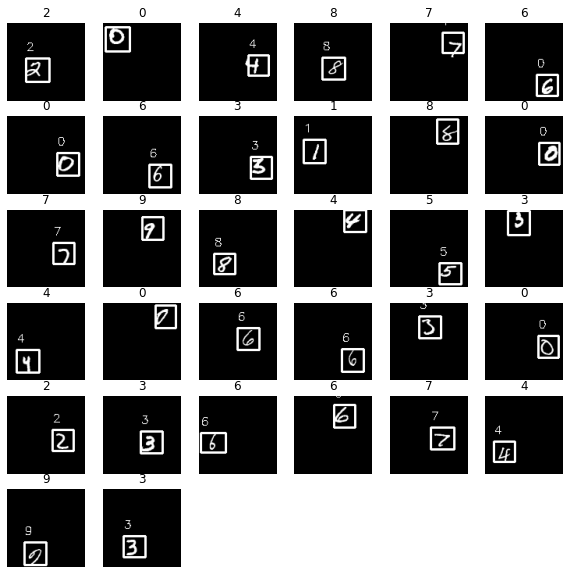

In [179]:
test()

## Calculating Model Accuracy

The IOU value of each predicted box will give us the accuracy of the bounding box prediction.

In [1]:
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    smoothing_factor = 1e-10

    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area
    
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

In [ ]:
def test():
    for i in test_loader.take(1):
        images = i[0]
        labels = i[1]['label'].numpy()
        bboxs = (i[1]['bbox'].numpy()*100).astype('int32')
        predictions = model.predict(images)
        pred_labels = predictions[0]
        pred_bboxs = (predictions[1]*100).astype('int32')
        
        iou = intersection_over_union(pred_bboxs, bboxs)
        iou_threshold = 0.6

        print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
        print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))
        
        plt.figure(figsize=(10,10))
        for n in range(32):
            ax = plt.subplot(6,6,n+1)
            img = np.squeeze(images[n], axis=-1)
            img = cv2.rectangle(img, (pred_bboxs[n][0], pred_bboxs[n][1]), (pred_bboxs[n][2], pred_bboxs[n][3]),(255,0,0), 2)
            pred_label = str(np.argmax(pred_labels[n]))
            cv2.putText(img, pred_label, (pred_bboxs[n][0], pred_bboxs[n][1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
            plt.imshow(img, cmap='gray')
            plt.title(labels[n])
            plt.axis('off')